<a href="https://colab.research.google.com/github/timothewt/Bird_Pictures_Recognition/blob/main/CNN_Photos_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Downloading birds pictures

In [2]:
import urllib.request
import os
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import math

Setting the environment in the correct directory and getting the API's secret key and the datasets

In [3]:
if os.getcwd() == "/content":
  os.chdir("drive/MyDrive/CNN")
with open("api_secret_key.txt") as f:
  api_secret_key = f.read()

Installing the Flickr's API to retrieve photos

In [4]:
!pip install -q flickrapi
from flickrapi import FlickrAPI
flickr = FlickrAPI("dee4b1d3673f1a96f5261e091a56f42a", api_secret_key, format='parsed-json')

Retrieving the photos as arrays

In [5]:
def get_pictures_as_array(text: str, number: int, starting_page: int = 1) -> np.array:
  # Using the Flickr API, retrieves photos corresponding to a text
  pages_num = min(math.floor((number - 1) // 500) + 1, 8)

  pages = [
      flickr.photos.search(text=text, per_page=min(500, number), page=(page_num + starting_page), extras="url_q", sort='relevance')['photos'] for page_num in range(1, pages_num + 1)
    ]
    
  photos = []

  # print(f"Downloading {text} photos..")

  for i, page in enumerate(pages):
    # print(f"Page num.{i + 1}")
    photos.extend([np.array(Image.open(BytesIO(requests.get(photo['url_q']).content))) for photo in page["photo"]])

  # print("Done")

  photos = np.array([photo for photo in photos if photo.shape == (150,150,3)])

  return photos[:number]

Defining the classes or labels of all the different images

In [6]:
classes = ['Eastern_Bluebird', 'Beach', 'Forest', 'Mountains', 'Car']

Utility functions

In [7]:
def correct_channels(images: np.array):
  # The channels used for the CNN are swaped from (0,1,2) to (2,0,1) so we need to correct the order to display the image
  return np.transpose(images, (0, 2, 3, 1))

In [8]:
def plot(series, title, x_label, y_label):
  # Used to plot the evolution of the model's performance
  fig = plt.figure(figsize=(7, 3))
  ax = fig.add_subplot()
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.plot(series)
  plt.show()

In [9]:
def show_images(images: np.array) -> None:
  # Used to show an array of images
  fig_dim = nrows, ncols = min(len(images), 6), len(images) // 6 + 1
  fig_size = tuple(dim * 3.5 for dim in fig_dim)
  fig = plt.figure(figsize=fig_size)
  for i, image in enumerate(images):
    fig.add_subplot(ncols, nrows, i + 1)
    plt.imshow(image, interpolation='nearest')
    plt.axis('off')
  
  plt.subplots_adjust(wspace=0, hspace=.05)
  plt.show()

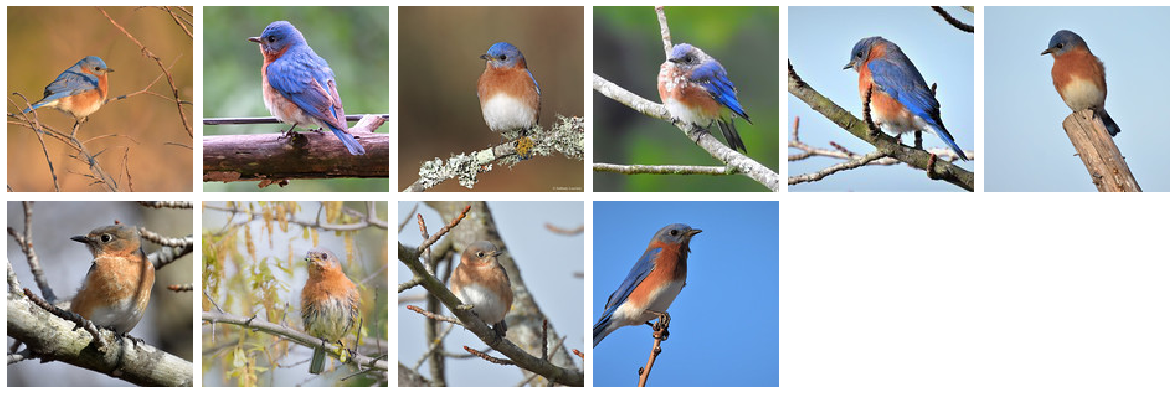

In [10]:
show_images(get_pictures_as_array("Eastern Bluebird", 10))

Downloading the images dataset

In [11]:
datasets = []
for img_class in classes:
  # Checking if the dataset already exists in the folder
  if (os.path.isfile(f"dataset_{img_class}.npy")):
    datasets.append(np.load(f"dataset_{img_class}.npy"))
  else:
    dataset = get_pictures_as_array(img_class.replace('_', ' '), 4_000)
    np.save(f"dataset_{img_class}", dataset)
    datasets.append(dataset)

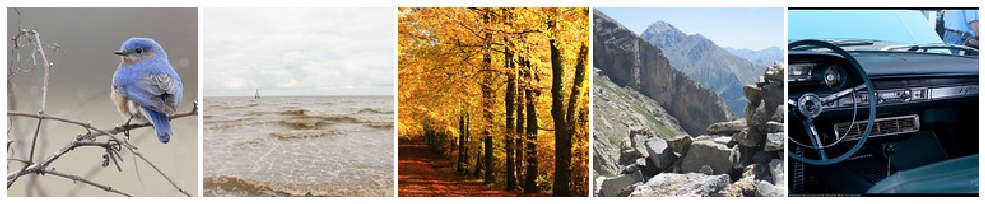

Eastern_Bluebird, Beach, Forest, Mountains, Car


In [12]:
show_images([datasets[i][1] for i in range(len(datasets))])
print(', '.join([classes[label] for label in range(len(datasets))]))

Once the dataset done, we can now build the CNN to classify the images as Bird or Not bird

## Building the CNN model

Importing PyTorch modules

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Building the dataset for the model
We first label, merge and shuffle all the datasets

In [15]:
dataset = []
for index, images in enumerate(datasets):
  dataset.extend([(image, index) for image in images])
dataset = np.array(dataset, dtype='object')
np.random.shuffle(dataset)

We set the data into small batches.

Each batch has a tensor of images (shape (3, 150, 150)) and a corresponding tensor of labels.

In [16]:
batch_size = 50
dataset_batches = []
for batch_num in range(0, batch_size * (len(dataset) // batch_size), batch_size):
  dataset_batches.append(
    (
        torch.tensor(np.array([np.transpose(img / 255, (2, 0, 1)) for img, _ in dataset[batch_num: batch_num + batch_size]]), device=device).float(),
        torch.tensor(np.array([label for _, label in dataset[batch_num: batch_num + batch_size]]), device=device)
    )
  )
test_batch = dataset_batches[-1]
dataset_batches = dataset_batches[:-1]

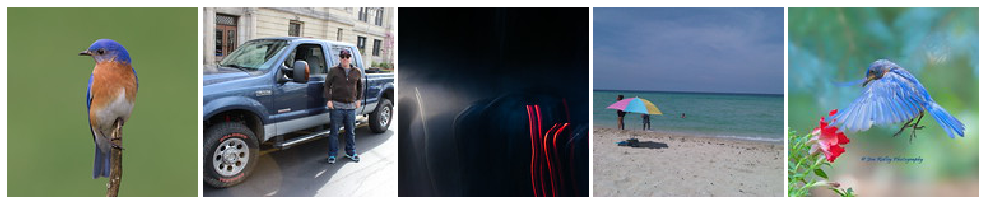

Eastern_Bluebird, Car, Car, Beach, Eastern_Bluebird


In [24]:
show_images(correct_channels(dataset_batches[2][0][:5].cpu()))
print(', '.join([classes[label] for label in dataset_batches[2][1][:5]]))

### CNN model

It consists of:
- 3 layers of 2D Convolution -> Batch normalization -> LeakyReLU
- 2 fully connected layers.
- A Sigmoid activation in order to get probabilities

In [18]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv_layer = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(6),
      nn.LeakyReLU(.2, inplace=True),
      # The model works better without the max pooling
      # nn.MaxPool2d(kernel_size=2),

      nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(12),
      nn.LeakyReLU(.2, inplace=True),
      # nn.MaxPool2d(kernel_size=2),

      nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(24),
      nn.LeakyReLU(.2, inplace=True),
      # nn.MaxPool2d(kernel_size=2),

      nn.Conv2d(in_channels=24, out_channels=48, kernel_size=5, stride=3, padding=2),
      nn.BatchNorm2d(48),
      nn.LeakyReLU(.2, inplace=True),
      # nn.MaxPool2d(kernel_size=2),

      nn.Dropout2d(.3)
    )
    self.fc = nn.Sequential(
        nn.Linear(2352, 1024),
        nn.Linear(1024, len(classes)),
        nn.Sigmoid()
    )

  def forward(self, rgb_image):
    out1 = self.conv_layer(rgb_image)
    return self.fc(torch.flatten(out1, 1))

## Training the model
The training function goes through the batches and plots the evolution

In [46]:
def train(num_epochs, dataset, model, optimizer):
  loss_fn = nn.CrossEntropyLoss()
  
  loss_hist = np.zeros(num_epochs)
  acc_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
      images, labels = dataset_batches[t % len(dataset_batches)]
      output = model(images)
      loss = loss_fn(output, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      accuracy = round(float((dataset_batches[t % len(dataset_batches)][1] == torch.max(output, 1)[1]).sum() / len(dataset_batches[t % len(dataset_batches)][1])), 3)

      if (t + 1) % (int(num_epochs / 10)) == 0 and t !=0:
          print(f"Epoch {t + 1} - Loss: {loss.item()}, Acc: {accuracy * 100}%")
      loss_hist[t] = loss.item()
      acc_hist[t] = accuracy

  print("--- Training finished ---")
  plot(loss_hist, "Evolution of the error", "Epoch", "Cross Entropy Error")
  plot(acc_hist, "Evolution of the accuracy", "Epoch", "Accuracy")

Defining the model and the optimizer (Adam with a standard learning rate)

In [47]:
model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.00015)

Training the model

Epoch 1000 - Loss: 1.1488271951675415, Acc: 76.0%
Epoch 2000 - Loss: 1.1430761814117432, Acc: 78.0%
Epoch 3000 - Loss: 1.1280382871627808, Acc: 82.0%
Epoch 4000 - Loss: 1.010920524597168, Acc: 82.0%
Epoch 5000 - Loss: 1.0505166053771973, Acc: 88.0%
Epoch 6000 - Loss: 1.0000814199447632, Acc: 88.0%
Epoch 7000 - Loss: 1.0511119365692139, Acc: 86.0%
Epoch 8000 - Loss: 1.0519577264785767, Acc: 88.0%
Epoch 9000 - Loss: 1.1085283756256104, Acc: 80.0%
Epoch 10000 - Loss: 0.9926007986068726, Acc: 94.0%
--- Training finished ---


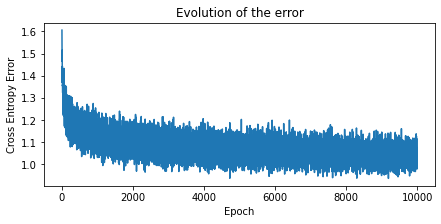

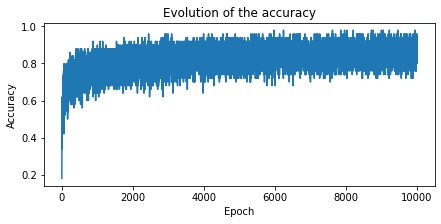

In [48]:
train(10_000, dataset_batches, model, optimizer)

## Testing the model

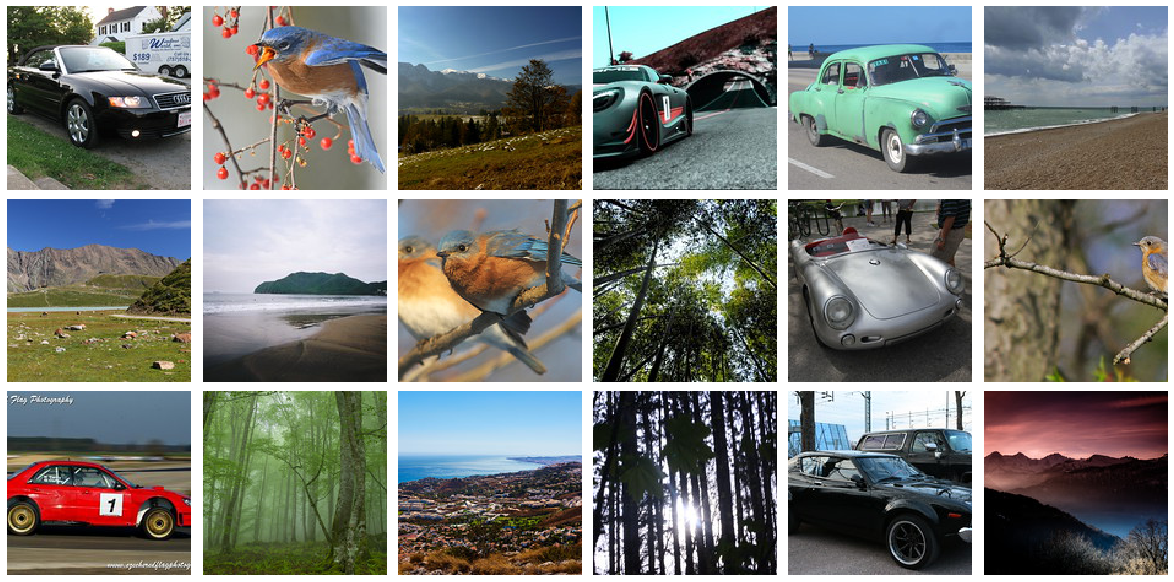

Predicted labels: 
Car, Eastern_Bluebird, Mountains, Car, Beach, Beach
Mountains, Mountains, Eastern_Bluebird, Forest, Car, Eastern_Bluebird
Car, Forest, Mountains, Forest, Car, Mountains


In [49]:
image_nb = 18
test_images = test_batch[0][:image_nb]

predictions = [classes[torch.argmax(pred)] for pred in model(test_images)]

show_images(correct_channels(test_images.cpu()))

newline = '\n'

print(f"Predicted labels: \n{newline.join([', '.join(predictions[i:i+6]) for i in range(0, image_nb, 6)])}")